In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
sns.color_palette("tab10")


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [2]:
df = pd.read_excel("实验一数据.xlsx")
BPA = df.iloc[:,1:].to_numpy()
Theta = [{1},{2},{3},{1,2},{1,3},{2,3},{1,2,3}]


In [3]:
def methon3(BPA, comb_target_set):
    """
    使用W距离计算相似度与冲突度
    使用Deng熵计算信息熵
    """
    max_distance = wasserstein_distance(np.zeros(BPA.shape[1]), np.ones(BPA.shape[1]))
    sim_matrix = np.zeros((BPA.shape[0], BPA.shape[0]), float)
    for i in range(BPA.shape[0]):
        for j in range(i, BPA.shape[0]):
            if i == j:
                continue
            sim_matrix[i, j] = wasserstein_distance(BPA[i], BPA[j])
            sim_matrix[j, i] = sim_matrix[i, j]
    sups = sim_matrix.sum(1).squeeze()
    Fs = get_sorting_factor(BPA, comb_target_set)
    msups = sups * Fs / (sups * Fs).sum()
    Ens = np.asarray([Deng_entropy(m, comb_target_set) for m in BPA])
    ucs = -msups + msups.mean()
    gsups = msups * ((Ens / Ens.sum()) ** ucs)
    ws = gsups / gsups.sum()
    MAE = (BPA.T * ws).sum(1)
    MAE = MAE / MAE.sum()
    RST = MAE[:]
    RSTs = np.zeros((BPA.shape[0] - 1, RST.shape[0]), float)
    for i in range(BPA.shape[0] - 1):
        RSTs[i] = RST
        RST = Dempster_combin(MAE, RST, comb_target_set)
        RST = RST / RST.sum()
    return RST, RSTs


def get_sorting_factor(BPA, combin_target_set):  # [{"A"}, {"B"}, {"C"}, {"A", "B"}]
    """
    by Paper: An improvement for combination rule in evidence theory
    """
    SMs = []
    for m in BPA:
        SM = np.zeros(shape=(len(m), len(m)))
        F = combin_target_set
        J = []
        for idx, value in enumerate(m):
            m[idx] = value / len(combin_target_set[idx])
        while True:
            i = np.argmax(m)
            if m[i] == -np.Inf:
                break
            J.append(combin_target_set[i])
            m[i] = -np.Inf
        for _set in combin_target_set:
            if _set in F and _set in J:
                SM[F.index(_set), J.index(_set)] = 1
        SMs.append(SM)
    SMs = np.stack(SMs, 0)
    DMs = SMs - np.sum(SMs, axis=0) / BPA.shape[0]
    DM_abs = -np.abs(DMs).sum(axis=1).sum(axis=1)
    Fs = len(combin_target_set) * np.exp(DM_abs) / np.exp(DM_abs).sum()
    return Fs


# def get_sorting_factor(BPA):
#     SMs = np.zeros(shape=(BPA.shape[0], BPA.shape[1], BPA.shape[1]), dtype=float)
#     for index, m in enumerate(BPA):
#         J = np.argsort(m, kind="mergesort")
#         zero_end_idx = 0
#         for idx, j in enumerate(J):
#             if m[j] != 0:
#                 zero_end_idx = idx
#                 break
#         J[:zero_end_idx] = J[:zero_end_idx][::-1]
#         J = J[::-1]
#         for i, j in enumerate(J):
#             SMs[index, i, j] = 1
#     DMs = SMs - SMs.sum(axis=0) / SMs.shape[0]
#     DMs = np.abs(DMs).sum(1).sum(1)
#     Fs = DMs.shape[0] * np.exp(-1 * DMs) / np.exp(-1 * DMs).sum()
#     return Fs


def Deng_entropy(m, comb_target_set):
    En = [
        mA * np.log2(mA / (2 ** len(setA) - 1))
        for mA, setA in zip(m, comb_target_set)
        if mA != 0
    ]
    return sum(En)


def Dempster_combin(m1, m2, comb_target_set):
    new_mass = {str(s): 0 for s in comb_target_set}
    K = 0
    for idx1, set1 in enumerate(comb_target_set):
        for idx2, set2 in enumerate(comb_target_set):
            intersection_set = set1.intersection(set2)
            if len(intersection_set) == 0:
                K += m1[idx1] * m2[idx2]
            else:
                new_mass[str(intersection_set)] += m1[idx1] * m2[idx2]
    return np.asarray([i / (1 - K) for i in new_mass.values()])


In [155]:
for i in Dempster_combin(
    [0.4, 0.3, 0.1, 0.1, 0.1],
    [0.2, 0.2, 0.05, 0.5, 0.05],
    [{1}, {2}, {3}, {1, 2}, {1, 2, 3}],
):
    print("{:10.20f}".format(i))


[0.46575342 0.3630137  0.02054795 0.14383562 0.00684932]


In [4]:
def methon1(BPA, comb_target_set):
    """
    使用D矩阵计算相似度与冲突度
    使用Deng熵计算信息熵
    """
    martrixD = get_matrix_D(comb_target_set)
    sim_matrix = np.zeros((BPA.shape[0], BPA.shape[0]), float)
    for i in range(BPA.shape[0]):
        for j in range(i, BPA.shape[0]):
            if i == j:
                continue
            sim_matrix[i, j] = sim_by_martix_D(BPA[i], BPA[j], martrixD)
            sim_matrix[j, i] = sim_matrix[i, j]
    sups = sim_matrix.sum(1).squeeze()
    Fs = get_sorting_factor(BPA, comb_target_set)
    msups = sups * Fs / (sups * Fs).sum()
    # msups = sups
    Ens = np.asarray([Deng_entropy(m, comb_target_set) for m in BPA])
    ucs = -msups + msups.mean()
    gsups = msups * ((Ens / Ens.sum()) ** ucs)
    ws = gsups / gsups.sum()
    MAE = (BPA.T * ws).sum(1)
    RST = MAE[:]
    RSTs = np.zeros((BPA.shape[0] - 1, RST.shape[0]), float)
    for i in range(BPA.shape[0] - 1):
        RSTs[i] = RST
        RST = Dempster_combin(MAE, RST, comb_target_set)
        RST = RST / RST.sum()
    return RST, RSTs


def sim_by_martix_D(m1, m2, martrixD):
    subm = m1 - m2
    return 1 - np.sqrt((subm @ martrixD @ subm) / 2)


def get_matrix_D(comb_target_set):
    set_length = len(comb_target_set)
    D = np.zeros(shape=(set_length, set_length), dtype=float)
    for idx1, set1 in enumerate(comb_target_set):
        for idx2, set2 in enumerate(comb_target_set):
            D[idx1, idx2] = len(set1.intersection(set2)) / len(set1.union(set2))
    return D


In [5]:
def base_methon(BPA, comb_target_set):
    """
    基础方法，直接融合BPA
    """
    RST = BPA[0,:]
    RSTs = np.zeros((BPA.shape[0] - 1, RST.shape[0]), float)
    for i, row in enumerate(BPA[1:]):
        RSTs[i] = RST
        RST = Dempster_combin(RST, row, comb_target_set)
        RST = RST / RST.sum()
    return RST, RSTs


In [9]:
BPA = np.asarray(
    [
        [0.41, 0.29, 0.3,0],
        [0,0.9,0.1,0],
        [0.58,0.07,0,0.35],
        [0.55,0.1,0,0.35],
        [0.6,0.1,0,0.3],
    ]
)
BPA

array([[0.41, 0.29, 0.3 , 0.  ],
       [0.  , 0.9 , 0.1 , 0.  ],
       [0.58, 0.07, 0.  , 0.35],
       [0.55, 0.1 , 0.  , 0.35],
       [0.6 , 0.1 , 0.  , 0.3 ]])

In [14]:
combin_set = [{"A"}, {"B"}, {"C"}, {"A", "C"}]
RST, RSTs = base_methon(BPA, combin_set)
RSTs,RST

[0.         0.89690722 0.10309278 0.        ]
[0.        0.6350365 0.3649635 0.       ]
[0.         0.33206107 0.66793893 0.        ]
[0.         0.14215686 0.85784314 0.        ]


(array([[0.41      , 0.29      , 0.3       , 0.        ],
        [0.        , 0.89690722, 0.10309278, 0.        ],
        [0.        , 0.6350365 , 0.3649635 , 0.        ],
        [0.        , 0.33206107, 0.66793893, 0.        ]]),
 array([0.        , 0.14215686, 0.85784314, 0.        ]))

(array([[9.00000000e-01, 0.00000000e+00, 1.00000000e-01],
        [9.86301370e-01, 0.00000000e+00, 1.36986301e-02],
        [9.91735537e-01, 0.00000000e+00, 8.26446281e-03],
        [9.99914973e-01, 0.00000000e+00, 8.50267834e-05]]),
 array([9.99995276e-01, 0.00000000e+00, 4.72408955e-06]))

In [7]:
result1,results1 = base_methon(BPA,Theta)
result2,results2 = methon1(BPA,Theta)
result3,results3 = methon3(BPA,Theta)

K=inf
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan nan nan]
K=nan
[nan nan nan nan nan n

<ipython-input-3-b628753183a3>:105: RuntimeWarning: invalid value encountered in double_scalars
  return np.asarray([i / (1 - K) for i in new_mass.values()])
<ipython-input-4-feba55492c51>:33: RuntimeWarning: invalid value encountered in subtract
  subm = m1 - m2
<ipython-input-3-b628753183a3>:87: RuntimeWarning: invalid value encountered in log2
  mA * np.log2(mA / (2 ** len(setA) - 1))


In [146]:
results = pd.DataFrame(
    data=np.vstack([results1, results2, results3]), columns=df.columns[1:]
)
labals = ["base methon"] * 39 + ["methon1"] * 39 + ["methon2"] * 39
results["labels"] = labals
results["idx"] = [i for i in range(1, 40)] * 3


In [150]:
results = results[results.labels != "base methon"]


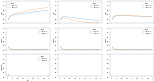

In [151]:
# plt.figure(figsize=(19, 10), dpi=100)
fig, subs = plt.subplots(3, 3, figsize=(19, 10), dpi=10, sharex=True)
# plt.subplots_adjust(hspace=0)
subs = subs.flatten()
sns.lineplot(
    x="idx",
    y="{θ1}",
    data=results,
    hue="labels",
    ax=subs[0],
).set_ylim(0, 1)
sns.lineplot(
    x="idx",
    y="{θ2}",
    data=results,
    hue="labels",
    ax=subs[1],
).set_ylim(0, 1)

sns.lineplot(
    x="idx",
    y="{θ3}",
    data=results,
    hue="labels",
    ax=subs[2],
).set_ylim(0, 1)

sns.lineplot(
    x="idx",
    y="{θ1,θ2}",
    data=results,
    hue="labels",
    ax=subs[3],
).set_ylim(0, 1)

sns.lineplot(
    x="idx",
    y="{θ1,θ3}",
    data=results,
    hue="labels",
    ax=subs[4],
).set_ylim(0, 1)

sns.lineplot(
    x="idx",
    y="{θ2,θ3}",
    data=results,
    hue="labels",
    ax=subs[5],
).set_ylim(0, 1)

sns.lineplot(
    x="idx",
    y="{θ1,θ2,θ3}",
    data=results,
    hue="labels",
    ax=subs[6],
).set_ylim(0, 1)

plt.ylim(0, 1)
plt.show()


In [148]:
results

,{θ1},{θ2},{θ3},"{θ1,θ2}","{θ1,θ3}","{θ2,θ3}","{θ1,θ2,θ3}",labels,idx
0,0.216100,0.240300,0.033700,2.423000e-01,1.678000e-01,2.590000e-02,7.390000e-02,base methon,1
1,0.295903,0.351007,0.166150,4.989484e-02,9.415835e-02,3.220092e-02,1.068535e-02,base methon,2
2,0.375173,0.325516,0.203675,2.790689e-02,4.581235e-02,1.969998e-02,2.216932e-03,base methon,3
3,0.302177,0.377894,0.275612,1.257375e-02,2.177499e-02,9.619946e-03,3.481847e-04,base methon,4
4,0.418300,0.163212,0.404892,1.962345e-03,9.914287e-03,1.678279e-03,4.066581e-05,base methon,5
...,...,...,...,...,...,...,...,...,...
112,0.682973,0.022079,0.294948,9.198775e-13,3.021380e-12,2.786337e-14,3.162605e-26,methon2,35
113,0.689213,0.020200,0.290588,4.251261e-13,1.444607e-12,1.165279e-14,6.027761e-27,methon2,36
114,0.695314,0.018475,0.286211,1.964190e-13,6.905128e-13,4.871967e-15,1.148537e-27,methon2,37
115,0.701282,0.016894,0.281825,9.072627e-14,3.299725e-13,2.036398e-15,2.187852e-28,methon2,38
